### Import des bibliothéques
---

In [29]:

import pandas as pd
import numpy as np
import os
import boto3

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

### Chargement des données
---

In [30]:
load_dotenv("secrets.env")

AWS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET = os.getenv("AWS_SECRET_ACCESS_KEY")
BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")

s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_KEY,
    aws_secret_access_key=AWS_SECRET
)
# chargement fichier du S3
s3.download_file(BUCKET_NAME, "data_wip_v5.xlsx", "geodechetS3.xlsx")


# Lecture des fichiers 
df = pd.read_excel("geodechetS3.xlsx")
df.head()

,Code_Dpt,Département,Région,année,densité_n-2,densité,pop_globale_n-2,pop_globale,tranche_age_0-24,tranche_age_25-59,...,Total_autres_dechets_n-2,Total_autres_dechets,Déblais_gravats_n-2,Déblais_gravats,Déchets_verts_n-2,Déchets_verts,Encombrants_n-2,Encombrants,Matériaux_recyclables_n-2,Matériaux_recyclables
0,01,Ain,Auvergne-Rhône-Alpes,2009,99.2,101.8,573868,588857,188068,281744,...,3298,4803,35646,37593,43862,45013,33967,34729,23227,25405
1,02,Aisne,Hauts-de-France,2009,73.1,73.4,537232,539547,170369,249910,...,421,1180,22870,24380,23034,24539,29857,31593,9266,10542
2,03,Allier,Auvergne-Rhône-Alpes,2009,46.6,46.6,342749,342559,86913,152570,...,1164,1867,13150,14374,17054,18612,11001,11932,7620,8564
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,2009,22.5,23.0,156203,159510,43500,70222,...,397,803,9577,11228,7093,8280,8652,9006,6829,7327
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,2009,23.9,24.5,132529,135883,37235,62716,...,696,1048,7943,8509,5857,6121,7709,7938,10344,10344


In [31]:
# pb avec col 'Code_dpt qui avait des str et int, erreur avec Onehotencoder
df['Code_Dpt'] = df['Code_Dpt'].astype(str)
df['Code_Dpt'].apply(type).value_counts()

# controle des colonnes
for col in df.columns:
    print(col, df[col].apply(type).unique())


Code_Dpt [<class 'str'>]
Département [<class 'str'>]
Région [<class 'str'>]
année [<class 'int'>]
densité_n-2 [<class 'float'>]
densité [<class 'float'>]
pop_globale_n-2 [<class 'int'>]
pop_globale [<class 'int'>]
tranche_age_0-24 [<class 'int'>]
tranche_age_25-59 [<class 'int'>]
tranche_age_60+ [<class 'int'>]
csp1_agriculteurs [<class 'int'>]
csp2_artisans_commerçant_chef_entreprises [<class 'int'>]
csp3_cadres_professions_intellectuelles [<class 'int'>]
csp4_professions_intermédiaires [<class 'int'>]
csp5_employés [<class 'int'>]
csp6_ouvriers [<class 'int'>]
csp7_retraités [<class 'int'>]
csp8_sans_activité [<class 'int'>]
nbre_entreprises [<class 'int'>]
nb_salaries_secteur_agricole [<class 'int'>]
nb_salaries_secteur_industrie [<class 'int'>]
nb_salaries_secteur_service [<class 'int'>]
nbre_entreprises_agricole [<class 'int'>]
nbre_entreprises_industrie [<class 'int'>]
nbre_entreprises_service [<class 'int'>]
tonnage_dechet_produit_n-2 [<class 'int'>]
tonnage_dechet_produit [<cla

In [32]:
print(df.columns)

Index(['Code_Dpt', 'Département', 'Région', 'année', 'densité_n-2', 'densité',
       'pop_globale_n-2', 'pop_globale', 'tranche_age_0-24',
       'tranche_age_25-59', 'tranche_age_60+', 'csp1_agriculteurs',
       'csp2_artisans_commerçant_chef_entreprises',
       'csp3_cadres_professions_intellectuelles',
       'csp4_professions_intermédiaires', 'csp5_employés', 'csp6_ouvriers',
       'csp7_retraités', 'csp8_sans_activité', 'nbre_entreprises',
       'nb_salaries_secteur_agricole', 'nb_salaries_secteur_industrie',
       'nb_salaries_secteur_service', 'nbre_entreprises_agricole',
       'nbre_entreprises_industrie', 'nbre_entreprises_service',
       'tonnage_dechet_produit_n-2', 'tonnage_dechet_produit',
       'Total_autres_dechets_n-2', 'Total_autres_dechets',
       'Déblais_gravats_n-2', 'Déblais_gravats', 'Déchets_verts_n-2',
       'Déchets_verts', 'Encombrants_n-2', 'Encombrants',
       'Matériaux_recyclables_n-2', 'Matériaux_recyclables'],
      dtype='object')


### Modéle Basiline
---

In [33]:
targets=['Déchets_verts', 'Total_autres_dechets', 'Déblais_gravats','Encombrants','Matériaux_recyclables']

# 1. Séparation des données
Y = df['Déchets_verts']
X = df.drop(columns=targets)

# 2. Split du jeu de données
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. Pipeline de prétraitement

numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Colonnes catégorielles (types texte ou catégoriel),
categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numériques :", numerical_columns)
print("Catégorielles :", categorical_columns)

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("standardization", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first"))
])

feature_encoder = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
])

# Transformation des données
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)

# Entraînement des modèles de régression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

# 5. Prédictions
Y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

# 6. Évaluation des performances
print("\n=== Score R2 ===")
print(f"R2 Score (Train): {r2_score(Y_train, Y_train_pred):.4f}")
print(f"R2 Score (Test) : {r2_score(Y_test, Y_test_pred):.4f}\n")


# Évaluation
mae = mean_absolute_error(Y_test, Y_test_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)
moy_dechets_verts= round(df['Déchets_verts'].sum()/len(df['Déchets_verts']),2)

# distribution des erreurs, prenant prediction et variable cible on calcule l'erreur et on affiche la distribution de cette erreur pour la variable"

print(f"\nLes déchets verts réprésentent {moy_dechets_verts} tonnes")
print(f"MAE : {mae:.2f}") #  Moyenne des écarts absolus entre les prédictions et les valeurs réelles.
print(f"MSE : {mse:.2f}") # erreur quadratique au carré, penalise les grandes erreurs
print(f"RMSE : {rmse:.2f}") # racine carrée marge d'erreur, même unité que ma target

print("\nLe dataset contient des features quasi-redondantes par rapport à la cible,\n" \
"facilitant l’apprentissage “direct” de la valeur cible et conduisant à une performance surévaluée.")

Numériques : ['année', 'densité_n-2', 'densité', 'pop_globale_n-2', 'pop_globale', 'tranche_age_0-24', 'tranche_age_25-59', 'tranche_age_60+', 'csp1_agriculteurs', 'csp2_artisans_commerçant_chef_entreprises', 'csp3_cadres_professions_intellectuelles', 'csp4_professions_intermédiaires', 'csp5_employés', 'csp6_ouvriers', 'csp7_retraités', 'csp8_sans_activité', 'nbre_entreprises', 'nb_salaries_secteur_agricole', 'nb_salaries_secteur_industrie', 'nb_salaries_secteur_service', 'nbre_entreprises_agricole', 'nbre_entreprises_industrie', 'nbre_entreprises_service', 'tonnage_dechet_produit_n-2', 'tonnage_dechet_produit', 'Total_autres_dechets_n-2', 'Déblais_gravats_n-2', 'Déchets_verts_n-2', 'Encombrants_n-2', 'Matériaux_recyclables_n-2']
Catégorielles : ['Code_Dpt', 'Département', 'Région']

=== Score R2 ===
R2 Score (Train): 0.9934
R2 Score (Test) : 0.9645


Les déchets verts réprésentent 41053.16 tonnes
MAE : 3473.81
MSE : 44334786.74
RMSE : 6658.44

Le dataset contient des features quasi-re

### Réduire l'Overfitting 
---

In [34]:
# avec la corrélation simple (Pearson) qui mesure le lien direct entre deux variables, chaque variable est indépendnate 
# recherche variables corrélées > 0.8 et sup les colonnes
Y = df['Déchets_verts'] 

# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include='number').columns

# Calcul de la corrélation uniquement sur les colonnes numériques
correlation_target = df[numeric_cols].corr()[Y.name]

# Filtrer les colonnes avec corrélation absolue > 0.8 (hors la cible)
high_corr = correlation_target[correlation_target.abs() > 0.8].drop(Y.name)

print("Colonnes fortement corrélées avec la cible (>0.8) :")
print(high_corr)

# Optionnel : supprimer ces colonnes du DataFrame
cols_to_drop = high_corr.index.tolist()
df_reduced = df.drop(columns=cols_to_drop)

# sup col avec redondances
# df_reduced=df_reduced.drop(columns=['Département', 'Région','densité_n-2','pop_globale_n-2', 'Total_autres_dechets_n-2', 'Déblais_gravats_n-2', 'Encombrants_n-2', 'Matériaux_recyclables_n-2'])
df_reduced=df_reduced.drop(columns=['Code_Dpt', 'Région','densité_n-2','pop_globale_n-2', 'Total_autres_dechets_n-2', 'Déblais_gravats_n-2', 'Encombrants_n-2', 'Matériaux_recyclables_n-2'])


Colonnes fortement corrélées avec la cible (>0.8) :
tonnage_dechet_produit_n-2    0.894860
tonnage_dechet_produit        0.917559
Déchets_verts_n-2             0.976116
Name: Déchets_verts, dtype: float64


### Sauvegarde dans S3 de mon new df_reduced
---

In [35]:
# convertir df en csv
csv_buffer = StringIO()
df_reduced.to_csv(csv_buffer, index=False)

# initialiser S3 et envoie fichier sur S3
s3 = boto3.client("s3", 
                  aws_access_key_id=AWS_KEY, 
                  aws_secret_access_key=AWS_SECRET)


file_name_s3 = 'df_reduced.csv'

s3.put_object(Bucket=BUCKET_NAME, Key=file_name_s3, Body=csv_buffer.getvalue())

print(f"Le fichier {file_name_s3} a été enregistré sur le bucket {BUCKET_NAME}")


Le fichier df_reduced.csv a été enregistré sur le bucket mygeodechet


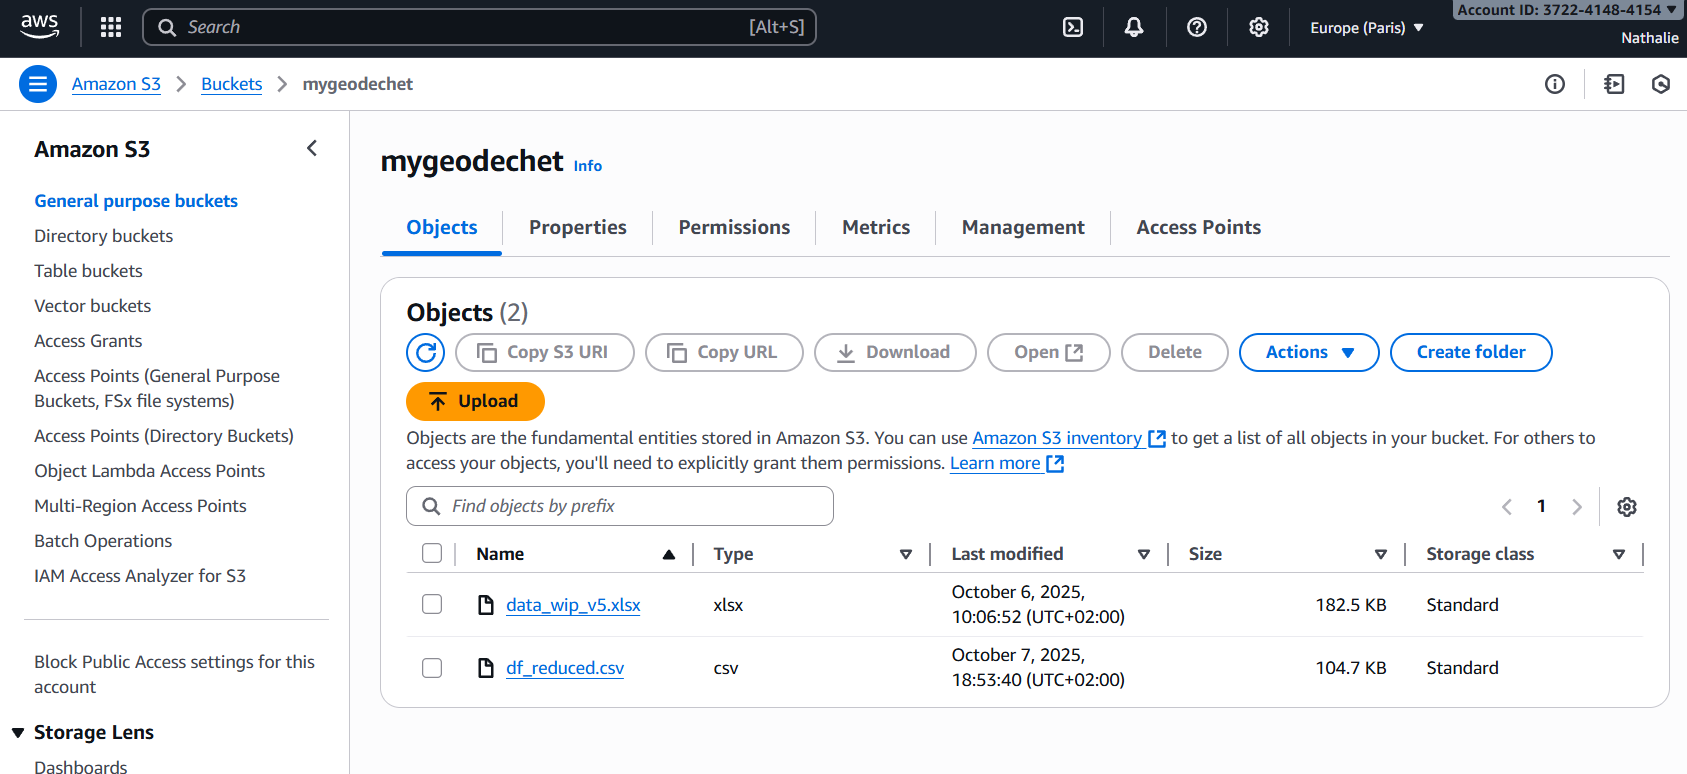

### Modéle LR reajusté (df_reduced)
---

In [36]:
targets=['Déchets_verts', 'Total_autres_dechets', 'Déblais_gravats','Encombrants','Matériaux_recyclables']

# 1. Séparation des données
Y = df_reduced['Déchets_verts']
X = df_reduced.drop(columns=targets)

# 2. Split du jeu de données
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. Pipeline de prétraitement

numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Colonnes catégorielles (types texte ou catégoriel),
categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numériques :", numerical_columns)
print("Catégorielles :", categorical_columns)

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("standardization", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first"))
])

feature_encoder = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
])

# Transformation des données
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)

# Entraînement des modèles de régression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

# 5. Prédictions
Y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

# 6. Évaluation des performances
print("\n=== Score R2 ===")
print(f"R2 Score (Train): {r2_score(Y_train, Y_train_pred):.4f}")
print(f"R2 Score (Test) : {r2_score(Y_test, Y_test_pred):.4f}\n")

# Évaluation
mae = mean_absolute_error(Y_test, Y_test_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)
moy_dechets_verts= round(df['Déchets_verts'].sum()/len(df['Déchets_verts']),2)

# distribution des erreurs, prenant prediction et variable cible on calcule l'erreur et on affiche la distribution de cette erreur pour la variable"

print(f"\nLes déchets verts réprésentent {moy_dechets_verts} tonnes")
print(f"MAE : {mae:.2f}") #  Moyenne des écarts absolus entre les prédictions et les valeurs réelles.
print(f"MSE : {mse:.2f}") # erreur quadratique au carré, penalise les grandes erreurs
print(f"RMSE : {rmse:.2f}") # racine carrée marge d'erreur, même unité que ma target

Numériques : ['année', 'densité', 'pop_globale', 'tranche_age_0-24', 'tranche_age_25-59', 'tranche_age_60+', 'csp1_agriculteurs', 'csp2_artisans_commerçant_chef_entreprises', 'csp3_cadres_professions_intellectuelles', 'csp4_professions_intermédiaires', 'csp5_employés', 'csp6_ouvriers', 'csp7_retraités', 'csp8_sans_activité', 'nbre_entreprises', 'nb_salaries_secteur_agricole', 'nb_salaries_secteur_industrie', 'nb_salaries_secteur_service', 'nbre_entreprises_agricole', 'nbre_entreprises_industrie', 'nbre_entreprises_service']
Catégorielles : ['Département']

=== Score R2 ===
R2 Score (Train): 0.9845
R2 Score (Test) : 0.9245


Les déchets verts réprésentent 41053.16 tonnes
MAE : 4849.81
MSE : 94195165.48
RMSE : 9705.42


### Modéle Ridge Régression
---

In [37]:
# Ridge est une régression linéaire avec une contrainte qui empêche les coefficients de devenir trop grands. 
# Elle réduit le risque de surapprentissage tout en conservant toutes les variables dans le modèle ; contrairement à Lasso,
#  elle ne met jamais de coefficient exactement à zéro
targets=['Déchets_verts', 'Total_autres_dechets', 'Déblais_gravats','Encombrants','Matériaux_recyclables']

# 1. Séparation des données
Y = df_reduced['Déchets_verts']
X = df_reduced.drop(columns=targets)

# 2. Split du jeu de données
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. Pipeline de prétraitement

numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Colonnes catégorielles (types texte ou catégoriel),
categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numériques :", numerical_columns)
print("Catégorielles :", categorical_columns)

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("standardization", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first"))
])

feature_encoder = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
])

# Transformation des données
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)

# Entraînement des modèles de régression 
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, Y_train)

# 5. Prédictions
Y_train_pred = ridge_model.predict(X_train)
Y_test_pred = ridge_model.predict(X_test)

# 6. Évaluation des performances
print("\n=== Score R2 ===")
print(f"R2 Score (Train): {r2_score(Y_train, Y_train_pred):.4f}")
print(f"R2 Score (Test) : {r2_score(Y_test, Y_test_pred):.4f}\n")

# Évaluation
mae = mean_absolute_error(Y_test, Y_test_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)
moy_dechets_verts= round(df['Déchets_verts'].sum()/len(df['Déchets_verts']),2)

# distribution des erreurs, prenant prediction et variable cible on calcule l'erreur et on affiche la distribution 
# de cette erreur pour la variable"

print(f"\nLes déchets verts réprésentent {moy_dechets_verts} tonnes")
print(f"MAE : {mae:.2f}") #  Moyenne des écarts absolus entre les prédictions et les valeurs réelles.
print(f"MSE : {mse:.2f}") # erreur quadratique au carré, penalise les grandes erreurs
print(f"RMSE : {rmse:.2f}") # racine carrée marge d'erreur, même unité que ma target

Numériques : ['année', 'densité', 'pop_globale', 'tranche_age_0-24', 'tranche_age_25-59', 'tranche_age_60+', 'csp1_agriculteurs', 'csp2_artisans_commerçant_chef_entreprises', 'csp3_cadres_professions_intellectuelles', 'csp4_professions_intermédiaires', 'csp5_employés', 'csp6_ouvriers', 'csp7_retraités', 'csp8_sans_activité', 'nbre_entreprises', 'nb_salaries_secteur_agricole', 'nb_salaries_secteur_industrie', 'nb_salaries_secteur_service', 'nbre_entreprises_agricole', 'nbre_entreprises_industrie', 'nbre_entreprises_service']
Catégorielles : ['Département']

=== Score R2 ===
R2 Score (Train): 0.9752
R2 Score (Test) : 0.9264


Les déchets verts réprésentent 41053.16 tonnes
MAE : 4894.77
MSE : 91917903.52
RMSE : 9587.38


In [38]:
# targets à prédire
targets = ['Total_autres_dechets','Déblais_gravats','Déchets_verts','Encombrants','Matériaux_recyclables']

# création df result
df_results = pd.DataFrame(columns=['cible','R2_train','R2_test','MAE','RMSE'])

# boucle sur chaque target
for target in targets:
    print(f"--- Traitement de {target}---")

    X = df_reduced.drop(columns=[target])
    Y = df_reduced[target]

    # Diviser train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 3. Pipeline de prétraitement

    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Colonnes catégorielles (types texte ou catégoriel),
    categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("standardization", StandardScaler())
])

    categorical_pipeline = Pipeline(steps=[
        ("encoder", OneHotEncoder(drop="first"))
    ])

    feature_encoder = ColumnTransformer(transformers=[
        ("num", numerical_pipeline, numerical_columns),
        ("cat", categorical_pipeline, categorical_columns)
    ])

    # Transformation des données
    X_train = feature_encoder.fit_transform(X_train)
    X_test = feature_encoder.transform(X_test)

    # Entraînement des modèles de régression 
    #ridge_model = Ridge(alpha=1.0)
    ridge_model = Ridge(alpha=0.001)
    ridge_model.fit(X_train, Y_train)

    # 5. Prédictions
    Y_train_pred = ridge_model.predict(X_train)
    Y_test_pred = ridge_model.predict(X_test)

    # Calcul des métriques
    r2_train = r2_score(Y_train, Y_train_pred)
    r2_test = r2_score(Y_test, Y_test_pred)
    y_mean = Y_train.mean()
    y_median = Y_train.median()  # mediane de la cible sur l'ensemble d'entraînement
    mae = mean_absolute_error(Y_test, Y_test_pred)
    mae_per = mae / y_median * 100 # MAE en % par rapport à la médiane
    rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
    rmse_per = rmse / y_median * 100 # RMSE en % par rapport à la médian
    mape = round(mean_absolute_percentage_error(Y_test, Y_test_pred) * 100, 2)  # en %

    # Stocker les résultats
    df_results = pd.concat([df_results, pd.DataFrame([{
        'cible': target,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'MOYENNE': y_mean,
        'MEDIANE': y_median,
        'MAE': mae,
        'MAE_%': mae_per,
        'RMSE': rmse,
        'RMSE_%': rmse_per,
        'MAPE': mape
    }])], ignore_index=True)

    
#     # Sauvegarder le modèle
#     with open(f'model_ridge_{target}.pkl','wb') as f:
#         pickle.dump(grid.best_estimator_, f)

df_results.head()

--- Traitement de Total_autres_dechets---
--- Traitement de Déblais_gravats---
--- Traitement de Déchets_verts---
--- Traitement de Encombrants---
--- Traitement de Matériaux_recyclables---


C:\Users\natha\AppData\Local\Temp\ipykernel_33624\3911881758.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([{


,cible,R2_train,R2_test,MAE,RMSE,MOYENNE,MEDIANE,MAE_%,RMSE_%,MAPE
0,Total_autres_dechets,0.849025,0.760063,2981.842293,4825.406518,8751.903166,6134.0,48.611710,78.666556,49.95
1,Déblais_gravats,0.972807,0.973392,4154.294810,6559.653256,37539.359404,28985.0,14.332568,22.631200,20.00
2,Déchets_verts,0.987248,0.933500,4499.576761,9110.768972,40337.666667,30564.0,14.721819,29.808824,14.44
3,Encombrants,0.970443,0.899639,4967.812595,8717.274225,32841.821229,26777.0,18.552536,32.555082,12.75
4,Matériaux_recyclables,0.981835,0.963466,2129.872715,2981.671963,21050.420857,16641.0,12.798947,17.917625,12.96


#### Analyse des dechets verts : Le modèle Ridge obtient un R²_test de 0,93 et un MAPE de 16 %. Cela signifie qu’il explique environ 93 % de la variabilité des déchets verts, avec une erreur moyenne d’environ 16 %. Le RMSE (9 157 t) étant proche du MAE (4 548 t), le modèle reste relativement stable, sans trop de grosses erreurs ponctuelles

In [39]:
df['Déchets_verts'].sum()

27587724

### Modéme Lasso Regression
---

In [40]:
# targets à prédire
targets = ['Total_autres_dechets','Déblais_gravats','Déchets_verts','Encombrants','Matériaux_recyclables']

# création df result
df_results = pd.DataFrame(columns=['cible','R2_train','R2_test','MAE','RMSE'])

# boucle sur chaque target
for target in targets:
    print(f"--- Traitement de {target}---")

    X = df_reduced.drop(columns=[target])
    Y = df_reduced[target]

    # Diviser train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 3. Pipeline de prétraitement

    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Colonnes catégorielles (types texte ou catégoriel),
    categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("standardization", StandardScaler())
])

    categorical_pipeline = Pipeline(steps=[
        ("encoder", OneHotEncoder(drop="first"))
    ])

    feature_encoder = ColumnTransformer(transformers=[
        ("num", numerical_pipeline, numerical_columns),
        ("cat", categorical_pipeline, categorical_columns)
    ])

    # Transformation des données
    X_train = feature_encoder.fit_transform(X_train)
    X_test = feature_encoder.transform(X_test)

    # Entraînement des modèles de régression 
    #ridge_model = Ridge(alpha=1.0)
    lasso_model = Lasso(alpha=1.0)
    lasso_model.fit(X_train, Y_train)

    # 5. Prédictions
    Y_train_pred = lasso_model.predict(X_train)
    Y_test_pred = lasso_model.predict(X_test)

    # Calcul des métriques
    r2_train = r2_score(Y_train, Y_train_pred)
    r2_test = r2_score(Y_test, Y_test_pred)
    y_mean = Y_train.mean()
    y_median = Y_train.median()  # mediane de la cible sur l'ensemble d'entraînement
    mae = mean_absolute_error(Y_test, Y_test_pred)
    mae_per = mae / y_median * 100 # MAE en % par rapport à la médiane
    rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
    rmse_per = rmse / y_median * 100 # RMSE en % par rapport à la médian
    mape = round(mean_absolute_percentage_error(Y_test, Y_test_pred) * 100, 2)  # en %

    # Stocker les résultats
    df_results = pd.concat([df_results, pd.DataFrame([{
        'cible': target,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'MOYENNE': y_mean,
        'MEDIANE': y_median,
        'MAE': mae,
        'MAE_%': mae_per,
        'RMSE': rmse,
        'RMSE_%': rmse_per,
        'MAPE': mape
    }])], ignore_index=True)

    
#     # Sauvegarder le modèle
#     with open(f'model_ridge_{target}.pkl','wb') as f:
#         pickle.dump(grid.best_estimator_, f)

df_results.head()

--- Traitement de Total_autres_dechets---


c:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2825661243.7065654, tolerance: 3381826.504696462
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\natha\AppData\Local\Temp\ipykernel_33624\1013118014.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([{
c:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5852050318.704202, tolerance: 52380230.1841635
  model = cd_fast.sparse_e

--- Traitement de Déblais_gravats---
--- Traitement de Déchets_verts---
--- Traitement de Encombrants---
--- Traitement de Matériaux_recyclables---


c:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2996519669.2578726, tolerance: 28339982.768683802
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1270916137.1986213, tolerance: 13025869.45868864
  model = cd_fast.sparse_enet_coordinate_descent(


,cible,R2_train,R2_test,MAE,RMSE,MOYENNE,MEDIANE,MAE_%,RMSE_%,MAPE
0,Total_autres_dechets,0.827793,0.740314,3089.455027,5020.076879,8751.903166,6134.0,50.366075,81.840184,51.83
1,Déblais_gravats,0.972197,0.975206,4110.289999,6332.161451,37539.359404,28985.0,14.180749,21.846339,18.85
2,Déchets_verts,0.986462,0.934354,4314.914124,9052.062568,40337.666667,30564.0,14.117636,29.616747,14.09
3,Encombrants,0.969378,0.900982,5010.376047,8658.772248,32841.821229,26777.0,18.711491,32.336603,13.14
4,Matériaux_recyclables,0.980177,0.960543,2141.647934,3098.633765,21050.420857,16641.0,12.869707,18.620478,13.82
